# Import dataset

In [ ]:
!pip install wget -q

In [ ]:
import wget, os, gzip, pickle, random, re, sys
import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, median, stdev
import seaborn as sns

In [ ]:
IMDB_URL = 'http://dlvu.github.io/data/imdb.{}.pkl.gz'
IMDB_FILE = 'imdb.{}.pkl.gz'
PAD, START, END, UNK = '.pad', '.start', '.end', '.unk'

In [ ]:
def load_imdb(final=False, val=5000, seed=0, voc=None, char=False):

    cst = 'char' if char else 'word'

    imdb_url = IMDB_URL.format(cst)
    imdb_file = IMDB_FILE.format(cst)

    if not os.path.exists(imdb_file):
        wget.download(imdb_url)

    with gzip.open(imdb_file) as file:
        sequences, labels, i2w, w2i = pickle.load(file)

    if voc is not None and voc < len(i2w):
        nw_sequences = {}

        i2w = i2w[:voc]
        w2i = {w: i for i, w in enumerate(i2w)}

        mx, unk = voc, w2i['.unk']
        for key, seqs in sequences.items():
            nw_sequences[key] = []
            for seq in seqs:
                seq = [s if s < mx else unk for s in seq]
                nw_sequences[key].append(seq)

        sequences = nw_sequences

    if final:
        return (sequences['train'], labels['train']), (sequences['test'], labels['test']), (i2w, w2i), 2

    # Make a validation split
    random.seed(seed)

    x_train, y_train = [], []
    x_val, y_val = [], []

    val_ind = set( random.sample(range(len(sequences['train'])), k=val) )
    for i, (s, l) in enumerate(zip(sequences['train'], labels['train'])):
        if i in val_ind:
            x_val.append(s)
            y_val.append(l)
        else:
            x_train.append(s)
            y_train.append(l)

    return (x_train, y_train), \
           (x_val, y_val), \
           (i2w, w2i), 2

In [ ]:
np.random.seed(1)
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=False)

In [ ]:
print('x_train details')
print(len(x_train))
print(len(x_train[0]))
print(x_train[0][:10])
print('y_train detail')
print(len(y_train))
print(y_train[:10])
print('x_val')
print(len(x_val))
print(len(x_val[0]))
print(x_val[0][:10])

x_train details
20000
10
[14, 19, 9, 379, 22, 11, 50, 52, 53, 290]
y_train detail
20000
[1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
x_val
5000
12
[6990, 27871, 9, 322, 9, 14, 23, 28, 168, 6]


In [ ]:
print(len(i2w))
print(i2w[:20])
i2w[141]

99430
['.pad', '.start', '.end', '.unk', 'the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'movie']


've'

In [ ]:
print(w2i['flim'])
print(w2i['.pad'])

46141
0


In [ ]:
print(len(w2i))
print(w2i.keys())

99430
dict_keys(['.pad', '.start', '.end', '.unk', 'the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'movie', 'for', 'with', 'but', 'film', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have', 'one', 'be', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'or', 'just', 'her', 'out', 'about', 'if', 'has', 'what', 'some', 'good', 'can', 'when', 'more', 'very', 'she', 'up', 'no', 'time', 'my', 'even', 'would', 'which', 'only', 'story', 'really', 'see', 'their', 'had', 'me', 'well', 'we', 'were', 'than', 'much', 'bad', 'get', 'been', 'other', 'do', 'people', 'great', 'will', 'also', 'into', 'because', 'how', 'don', 'him', 'first', 'most', 'made', 'its', 'them', 'then', 'make', 'way', 'could', 'too', 'movies', 'any', 'after', 'characters', 'think', 'watch', 'character', 'films', 'two', 'many', 'seen', 'being', 'love', 'plot', 'never', 'life', 'acting', 'where', 'show', 'did', 'best', 'know', 'little', 'over', 'off', 'ever', 'm

In [ ]:
print(x_train[141][:10])
item = [i2w[w] for w in x_train[141]]
print(item)
print(i2w[39])
content = ''
for w in item:
  content +=w + ' '
content

[880, 4, 122, 19, 127, 1035, 12, 4, 481, 7]
['possibly', 'the', 'best', 'movie', 'ever', 'created', 'in', 'the', 'history', 'of', 'jeffrey', 'combs', 'career', 'and', 'one', 'that', 'should', 'be', 'looked', 'upon', 'by', 'all', 'talent', 'in', 'hollywood', 'for', 'his', 'versatility', 'charisma', 'and', 'uniqueness', 'he', 'brings', 'through', 'his', 'characters', 'and', 'his', 'knowledge', 'of', 'acting']
who


'possibly the best movie ever created in the history of jeffrey combs career and one that should be looked upon by all talent in hollywood for his versatility charisma and uniqueness he brings through his characters and his knowledge of acting '

In [ ]:
numcls

2

In [ ]:
ln = np.array([len(x) for x in x_train])
print('min length',ln.min())
print('max length', ln.max())
print('Mean length', (ln.mean().astype(int)))

min length 10
max length 2514
Mean length 240


In [ ]:
sample_list = x_train[600:700]
print([len(x) for x in sample_list])

[55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]


standard deviation (or σ) is a measure of how dispersed the data is in relation to the mean. Low standard deviation means data are clustered around the mean, and high standard deviation indicates data are more spread out

Original Data
   mean: 240
 median: 180.0
Std Dev: 178.30030846860586


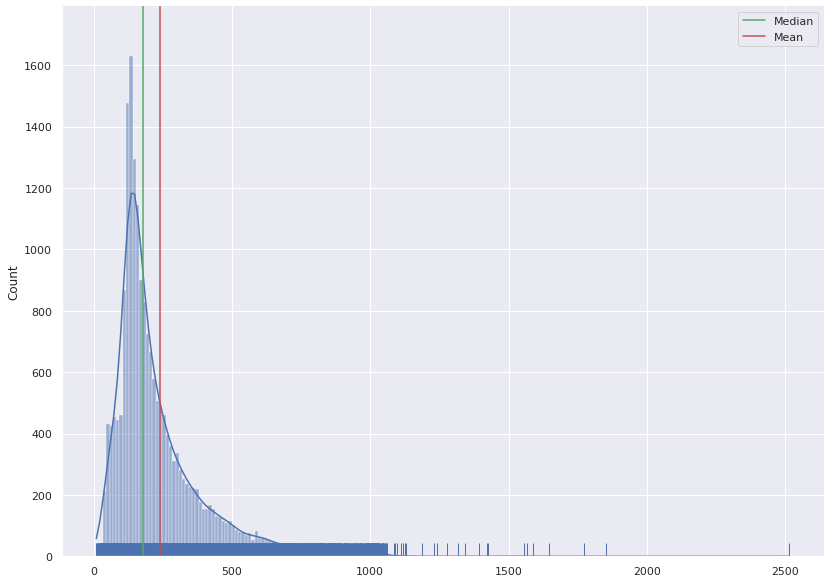

In [ ]:
print('Original Data')
print('   mean:',mean(ln))
print(' median:',median(ln))
print('Std Dev:',stdev(ln))
sns.displot(ln, kde=True, rug=True, height=8.27, aspect=11.7/8.27);
sns.set(rc={'figure.figsize':(5,20)})
plt.axvline(np.median(ln),color='g', linestyle='-', label='Median')
plt.axvline(np.mean(ln),color='r', linestyle='-', label='Mean')
plt.legend()
plt.show()

Cropped Data
   mean: 147
 median: 144.0
Std Dev: 32.01562118716424


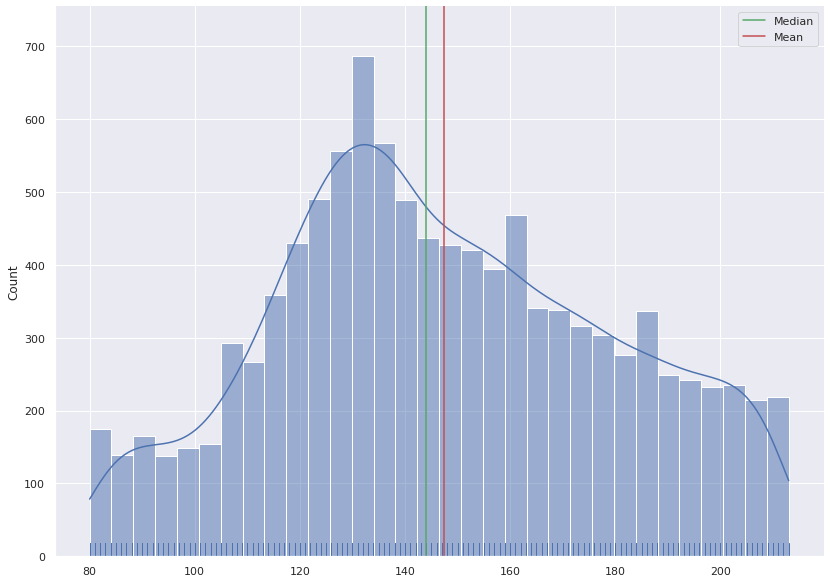

In [ ]:
start = 1500
end = 12000
x_new = x_train[start:end]
ln_new = np.array([len(x) for x in x_new])

print('Cropped Data')
print('   mean:',mean(ln_new))
print(' median:',median(ln_new))
print('Std Dev:',stdev(ln_new))
sns.displot(ln_new, kde=True, rug=True, height=8.27, aspect=11.7/8.27);
# sns.set(rc={'figure.figsize':(5,20)})
plt.axvline(np.median(ln_new),color='g', linestyle='-', label='Median')
plt.axvline(np.mean(ln_new),color='r', linestyle='-', label='Mean')
plt.legend()
plt.show()

Validation Data
total validation set: 5000
   mean: 242
 median: 179.0
Std Dev: 182.36501857538357


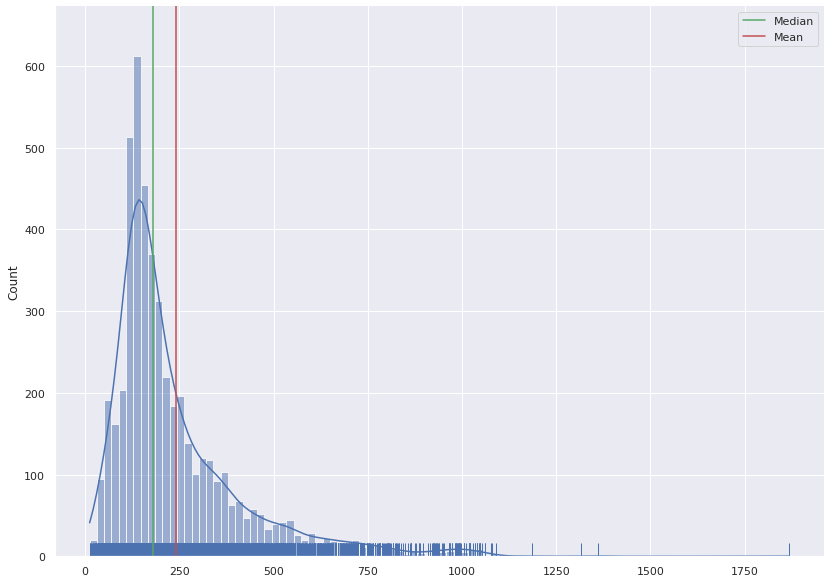

In [ ]:
ln_val = np.array([len(x) for x in x_val])
print('Validation Data')
print('total validation set:', len(ln_val))
print('   mean:',mean(ln_val))
print(' median:',median(ln_val))
print('Std Dev:',stdev(ln_val))
sns.displot(ln_val, kde=True, rug=True, height=8.27, aspect=11.7/8.27);
sns.set(rc={'figure.figsize':(5,20)})
plt.axvline(np.median(ln_val),color='g', linestyle='-', label='Median')
plt.axvline(np.mean(ln_val),color='r', linestyle='-', label='Mean')
plt.legend()
plt.show()

In [ ]:
# prepare the batch 
batch_length = np.int(mean(ln_new))
batch_length = np.int(ln_new.max())
batch_length

213

In [ ]:
X = []
for x in x_new:
  leng = len(x)
  if leng < batch_length:
    X.append(x+[w2i['.pad'] for x in range(batch_length - leng)])
  elif leng > batch_length: 
    X.append(x[:batch_length])
  else: X.append(x)
print(len(X))

10500


In [ ]:
ln_new = np.array([len(x) for x in X])

print('Sized Data')
print('      mean:',mean(ln_new))
print('    median:',median(ln_new))
print('   Std Dev:',stdev(ln_new))
print('Total data:',len(X))

Sized Data
      mean: 213
    median: 213.0
   Std Dev: 0.0
Total data: 10500


In [ ]:
batch_size = 64
X_train = torch.tensor(X, dtype=torch.long)
Y_train = torch.tensor(y_train[start:end])

In [ ]:
print(X_train.size())
print(Y_train.size())

torch.Size([10500, 213])
torch.Size([10500])


In [ ]:
trainset = torch.utils.data.TensorDataset( X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size= batch_size)

In [ ]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.size())

torch.Size([64, 213])


In [ ]:
print(example_targets)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
con =''
item =[i2w[x] for x in example_data[-1]]
content = ''
for w in item:
  content +=w + ' '
print('Sentance:',content)
print('Target:',example_targets[-1].item())

Sentance: br br how this film ever got a star average is beyond me the script is so banal and frankly an insult to whomevers life it is based upon the cinematography comes straight from the slick world of advertising and the talented ridley scott should be ashamed demi moore however shows none a surprise by participating in this film if one looks at her tracklist all in all a high concept style film that even don simpson would be ashamed of .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad .pad 
Target: 1


In [ ]:
def generate_batch(batch):
  # data, target = batch 
  label = torch.tensor([entry[1] for entry in batch])
  text = [entry[0] for entry in batch]
  offsets = [0] + [len(entry) for entry in text]
  # print(offsets)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  text = torch.cat(text)
  
  return text, offsets, label

In [ ]:
trainset = torch.utils.data.TensorDataset( X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size= batch_size, collate_fn=generate_batch)

In [ ]:
def varLenLoader(X, y, batch_size):
  X = np.array(X)
  total_len = len(X)
  bin = total_len*0.1
  decay = int(total_len/bin)
  for i in np.arange(0, X.shape[0], batch_size):
    x_temp = X[i:i + batch_size]
    y_mini = y[i:i + batch_size]

    ln = np.array([len(x) for x in x_temp])
    batch_length = ln.max()
    x_min = []
    for x in x_temp:
      leng = len(x)
      if leng < batch_length:
        x_min.append(x+[w2i['.pad'] for x in range(batch_length - leng)])
      else: x_min.append(x)
    x_min = torch.tensor(x_min, dtype=torch.long)
    y_mini = torch.tensor(y_mini)
    yield (x_min, y_mini)

    if i % decay == 0:
      if batch_size > 4:
        batch_size -= 1
      else: 
        batch_size == 4

# for inputs, target in varLenLoader(x_train, y_train, batch_size=64):
#   print(target.size())
#   # a =10

# 2. Build Model

In [ ]:
class NonRNN(nn.Module):
  def __init__(self, num_embeddings, embedding_dim=300):
    super(NonRNN, self).__init__()
    self.embedding = nn.Embedding(num_embeddings, embedding_dim)   
    self.fc1 = nn.Linear(300, 300)
    self.fc2 = nn.Linear(300, 2)

  def forward(self, sentence):
    x = self.embedding(sentence)
    x = F.relu(self.fc1(x))
    x = torch.max(x, 1).values
    x = self.fc2(x)
    return x 

In [ ]:
output = nonrr(example_data)
output[0]

tensor([-1.1356,  2.3052], grad_fn=<SelectBackward>)

In [ ]:
def fit(model:NonRNN, epochs=3, lr=0.001, step_size=10, batch_size=64):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  # print('learning rate:',lr)
  model.train()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(epochs):
    print('epoch:',epoch)
    
    correct = 0
    tr_acc = 0
    running_loss = 0.0
    i = 0
    for inputs, targets in varLenLoader(x_train, y_train, batch_size):     
      # print('input',inputs)
      outputs = model(inputs)
      # print('output',outputs)
      # print('targets',targets)
      loss = F.cross_entropy(outputs, targets)
      # print('loss',loss)
      running_loss += loss.item()
      # print('running loss', running_loss)
      
      optimizer.zero_grad()
      # print('zero_grad')
      loss.backward()
      # print('backward track complete')
      optimizer.step()
      # print('optimzer next step')

      if i % step_size == 0: 
        avg_loss = running_loss/step_size
        train_loss.append(avg_loss)
  
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        tr_acc = (100. * correct / len(targets))
        train_acc.append(tr_acc)

        # print('loss:', avg_loss,'acc:', tr_acc)

        running_loss = 0.0
        correct = 0

        v_loss, v_acc = valid_eval(model, x_val, y_val)
        val_loss.append(v_loss)
        val_acc.append(v_acc) 
    try:
      print('loss,', mean(train_loss))
    except: pass

    # print('Epoch{}, loss: {}'.format(epoch, train_loss/len(train_loss)))
    i +=1
    
  return train_loss, val_loss, val_acc, train_acc

In [ ]:
def test_eval(model:NonRNN):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    
    for inputs, labels in enumerate(testloader, 0):
      inputs, labels = data
      outputs = model(inputs)
      test_loss += F.cross_entropy(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()

  test_loss /= len(testloader.dataset)
  test_accs = (100. * correct / len(testloader.dataset))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))
  return test_loss, test_accs

In [ ]:
def valid_eval(model:NonRNN, x, y):
  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    i = 0 
    for inputs, labels in varLenLoader(x, y,64):
      outputs = model(inputs)
      val_loss += F.cross_entropy(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      i +=1
  val_loss /= len(x)
  val_acc = (100. * correct / len(x))
  # print('Valid set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
  #   val_loss, correct, split,
  #   100. * correct / split))
  return val_loss, val_acc
# val_loss, val_acc = valid_eval(nonrr, x_val, y_val)
# print(val_loss, val_acc)

In [ ]:
learning_rate = 0.001
epochs = 3
step_size = 20 # inverval steps for logging the loss and accuracy 
num_embeddings = len(w2i)

In [ ]:
nonrr = NonRNN(num_embeddings=num_embeddings)
train_loss, val_loss, val_acc, train_acc = fit(nonrr, lr=learning_rate, epochs=epochs, step_size=step_size)

epoch: 0
loss, 0.020315058029944096
epoch: 1
loss, 0.016067084717228057
epoch: 2
loss, 0.013575159664930581


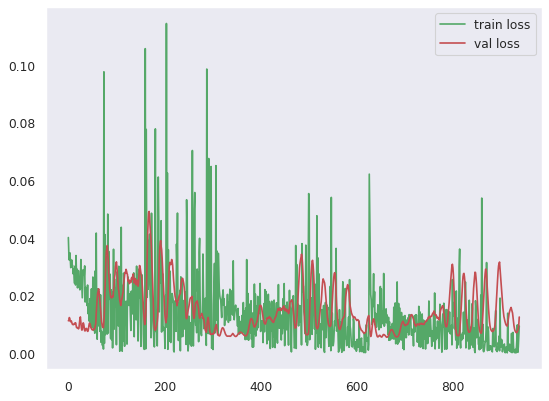

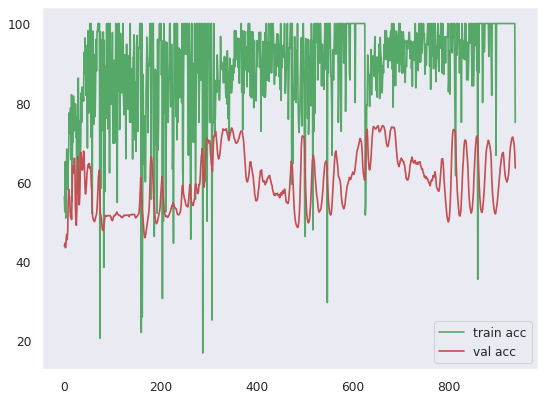

In [ ]:
# plt.plot(train_loss, color='r')
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, color='g', label='train loss')
plt.plot(val_loss, color='r', label='val loss')
plt.legend()
plt.grid()

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_acc, color='g', label='train acc')
plt.plot(val_acc, color='r', label='val acc')
plt.legend()
plt.grid()



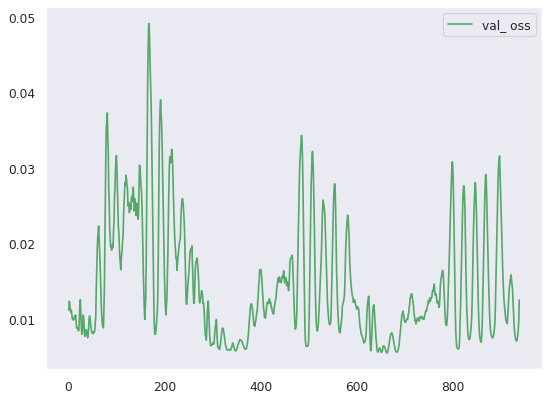

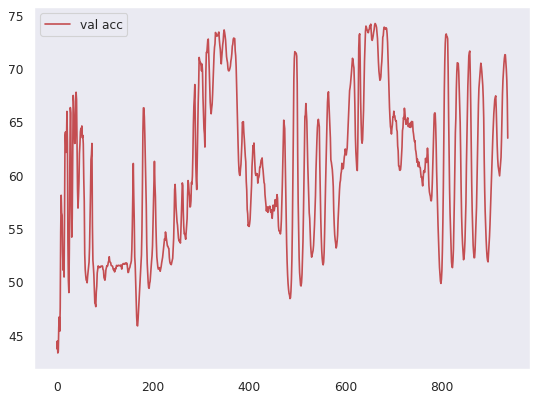

In [ ]:
# plt.plot(train_loss, color='r')
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(val_loss, color='g', label='val_ oss')
plt.legend()
plt.grid()

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(val_acc, color='r', label='val acc')
plt.legend()
plt.grid()

In [ ]:
v_loss, v_acc = valid_eval(nonrr, x_val, y_val)
print(v_loss, str(v_acc)+'%')

tensor(0.0125) 63.44%
